# Visual Classification experiments

## Overview
Experiments based on works in:
- Visual Classification via Description, Menon et al. 2022
- Waffling around for Performance, Roth et al. 2023

In [2]:
import json
from load import *
import torchmetrics
from tqdm import tqdm
import torch

In [3]:
def load_or_initialize_results(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        return {}
    
def save_results(results, file_path):
    with open(file_path, 'w') as file:
        json.dump(results, file, indent=4)

results_file_path = 'results/experiment_results.json'
results = load_or_initialize_results(results_file_path)

In [4]:

# Initialize the environment
seed_everything(hparams['seed'])

# Prepare the data loader
bs = hparams['batch_size']
dataloader = DataLoader(dataset, bs, shuffle=False, num_workers=16, pin_memory=True)  # Shuffle should be False for class-wise evaluation

# Load the model and preprocessing
print("Loading model...")
device = torch.device(hparams['device'])
model, preprocess = clip.load(hparams['model_size'], device=device, jit=False)
model.eval()
model.requires_grad_(False)

# Encode descriptions and labels
print("Encoding descriptions...")
description_encodings = compute_description_encodings(model)
label_encodings = compute_label_encodings(model)

Loading model...
Encoding descriptions...


In [5]:

# Number of classes
num_classes = len(dataset.classes)

# Evaluation metrics for overall and per-class accuracies
print("Evaluating...")
overall_lang_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
overall_lang_accuracy_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=5).to(device)

overall_clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
overall_clip_accuracy_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, top_k=5).to(device)

# Initialize dictionaries to track class-wise accuracy
class_wise_lang_accuracy = {i: torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device) for i in range(num_classes)}
class_wise_clip_accuracy = {i: torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device) for i in range(num_classes)}

Evaluating...


In [6]:

for batch_number, (images, labels) in enumerate(tqdm(dataloader)):    
    images = images.to(device)
    labels = labels.to(device)
    
    # Encode images
    image_encodings = model.encode_image(images)
    image_encodings = F.normalize(image_encodings)
    
    # Compute similarities and make predictions
    image_labels_similarity = image_encodings @ label_encodings.T
    clip_predictions = image_labels_similarity.argmax(dim=1)
    
    # Update overall and class-wise accuracies for CLIP
    overall_clip_accuracy_metric(image_labels_similarity, labels)
    overall_clip_accuracy_metric_top5(image_labels_similarity, labels)
    for i in range(num_classes):
        class_mask = labels == i
        if class_mask.any():
            class_wise_clip_accuracy[i](clip_predictions[class_mask], labels[class_mask])

    # Compute description-based predictions
    image_description_similarity = [None]*n_classes
    image_description_similarity_cumulative = [None]*n_classes

    for i, (k, v) in enumerate(description_encodings.items()):
        dot_product_matrix = image_encodings @ v.T
        
        if frequency_penalty_config:
            for descriptor in gpt_descriptions[k]:
                freq = descriptors_freq[freq_type].get(descriptor, 1)
                norm_freq = freq / max(descriptors_freq[freq_type].values())
                penalty_index = gpt_descriptions[k].index(descriptor)
                dot_product_matrix[:, penalty_index] /= norm_freq

        if similarity_penalty_config:
            class_average_sim = average_cosine_similarities.get(k, 0)  # Default to 0 if not found
            dot_product_matrix -= class_average_sim
        
        image_description_similarity[i] = dot_product_matrix
        image_description_similarity_cumulative[i] = aggregate_similarity(image_description_similarity[i])

    cumulative_tensor = torch.stack(image_description_similarity_cumulative,dim=1)
    descr_predictions = cumulative_tensor.argmax(dim=1)
    
    # Update overall and class-wise accuracies for descriptions
    overall_lang_accuracy_metric(cumulative_tensor.softmax(dim=-1), labels)
    overall_lang_accuracy_metric_top5(cumulative_tensor.softmax(dim=-1), labels)
    for i in range(num_classes):
        class_mask = labels == i
        if class_mask.any():
            class_wise_lang_accuracy[i](descr_predictions[class_mask], labels[class_mask])

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


In [7]:

# Print class-wise accuracies
print("\nClass-wise Description-based Accuracy:")
for i, acc in class_wise_lang_accuracy.items():
    class_name = dataset.classes[i]
    accuracy = 100 * acc.compute().item()
    print(f"Desc. Acc.: {accuracy:.3f}% - {class_name}")

print("\nClass-wise CLIP-Standard Accuracy:")
for i, acc in class_wise_clip_accuracy.items():
    class_name = dataset.classes[i]
    accuracy = 100 * acc.compute().item()
    print(f"CLIP Acc.: {accuracy:.3f}% - {class_name}")


Class-wise Description-based Accuracy:
Desc. Acc.: 83.333% - 001.Black_footed_Albatross
Desc. Acc.: 60.000% - 002.Laysan_Albatross
Desc. Acc.: 25.000% - 003.Sooty_Albatross
Desc. Acc.: 60.000% - 004.Groove_billed_Ani
Desc. Acc.: 50.000% - 005.Crested_Auklet
Desc. Acc.: 27.273% - 006.Least_Auklet
Desc. Acc.: 21.739% - 007.Parakeet_Auklet
Desc. Acc.: 27.778% - 008.Rhinoceros_Auklet
Desc. Acc.: 17.241% - 009.Brewer_Blackbird
Desc. Acc.: 83.333% - 010.Red_winged_Blackbird
Desc. Acc.: 46.667% - 011.Rusty_Blackbird
Desc. Acc.: 96.154% - 012.Yellow_headed_Blackbird
Desc. Acc.: 80.000% - 013.Bobolink
Desc. Acc.: 73.333% - 014.Indigo_Bunting
Desc. Acc.: 85.714% - 015.Lazuli_Bunting
Desc. Acc.: 92.857% - 016.Painted_Bunting
Desc. Acc.: 74.074% - 017.Cardinal
Desc. Acc.: 33.333% - 018.Spotted_Catbird
Desc. Acc.: 75.862% - 019.Gray_Catbird
Desc. Acc.: 13.793% - 020.Yellow_breasted_Chat
Desc. Acc.: 86.667% - 021.Eastern_Towhee
Desc. Acc.: 0.000% - 022.Chuck_will_Widow
Desc. Acc.: 27.586% - 023.Bra

In [8]:
acc_list = []
trivial_count = 0
print("Compare accuracies of description and CLIP-Standard")
for i, acc_class_wise in class_wise_lang_accuracy.items():
    for j, acc_clip_class_wise in class_wise_clip_accuracy.items():
        if i == j:
            class_name = dataset.classes[i]
            acc = acc_class_wise.compute().item() - acc_clip_class_wise.compute().item()
            acc_list.append(acc)
            if acc > 0.001 or acc < -0.001:
                print(f"Desc. Acc. - CLIP Acc.: {acc:.3f}% - {class_name}")
            else:
                trivial_count += 1
                print(f"Desc. Acc. - CLIP Acc.: Trivial - {class_name}")
print("Trivial count: ", trivial_count)

for i in range(len(sorted(acc_list))):
    print(f"{sorted(acc_list)[i]}")
print(sum(acc_list))

Compare accuracies of description and CLIP-Standard
Desc. Acc. - CLIP Acc.: -0.033% - 001.Black_footed_Albatross
Desc. Acc. - CLIP Acc.: -0.133% - 002.Laysan_Albatross
Desc. Acc. - CLIP Acc.: -0.071% - 003.Sooty_Albatross
Desc. Acc. - CLIP Acc.: 0.033% - 004.Groove_billed_Ani
Desc. Acc. - CLIP Acc.: 0.286% - 005.Crested_Auklet
Desc. Acc. - CLIP Acc.: -0.273% - 006.Least_Auklet
Desc. Acc. - CLIP Acc.: 0.174% - 007.Parakeet_Auklet
Desc. Acc. - CLIP Acc.: -0.222% - 008.Rhinoceros_Auklet
Desc. Acc. - CLIP Acc.: 0.138% - 009.Brewer_Blackbird
Desc. Acc. - CLIP Acc.: -0.033% - 010.Red_winged_Blackbird
Desc. Acc. - CLIP Acc.: -0.100% - 011.Rusty_Blackbird
Desc. Acc. - CLIP Acc.: Trivial - 012.Yellow_headed_Blackbird
Desc. Acc. - CLIP Acc.: -0.067% - 013.Bobolink
Desc. Acc. - CLIP Acc.: -0.067% - 014.Indigo_Bunting
Desc. Acc. - CLIP Acc.: 0.071% - 015.Lazuli_Bunting
Desc. Acc. - CLIP Acc.: Trivial - 016.Painted_Bunting
Desc. Acc. - CLIP Acc.: 0.185% - 017.Cardinal
Desc. Acc. - CLIP Acc.: 0.200%

In [9]:
class_wise_accuracies = {}
differences = {}
for i in range(num_classes):
    class_name = dataset.classes[i]
    desc_accuracy = 100 * class_wise_lang_accuracy[i].compute().item()
    clip_accuracy = 100 * class_wise_clip_accuracy[i].compute().item()
    
    # Calculate the difference between description-based and CLIP-standard accuracies
    difference = desc_accuracy - clip_accuracy
    
    # Store accuracies and their difference in the dictionary
    class_wise_accuracies[class_name] = {
        "Description-based Accuracy": desc_accuracy,
        "CLIP-Standard Accuracy": clip_accuracy,
        "Difference": difference
    }
    
    # Also store the difference separately for sorting
    differences[class_name] = difference

# Sort classes by the magnitude of difference
sorted_classes_by_difference = sorted(differences, key=differences.get, reverse=True)

# Reorganize the class-wise accuracies based on the sorted order
sorted_class_wise_accuracies = {class_name: class_wise_accuracies[class_name] for class_name in sorted_classes_by_difference}

# Structure the experimental results
experimental_results = {}
experimental_results["Class-wise Accuracies and Differences (Top 5)"] = [list(sorted_class_wise_accuracies.keys())[:5]]
experimental_results["Class-wise Accuracies and Differences (Bottom 5)"] = [list(sorted_class_wise_accuracies.keys())[-5:]]
experimental_results["Trivial Count"] = trivial_count
experimental_results["Class-wise Accuracies and Differences"] = sorted_class_wise_accuracies
experimental_results["Total Description-based Top-1 Accuracy: "] = 100*overall_lang_accuracy_metric.compute().item()
experimental_results["Total Description-based Top-5 Accuracy: "] = 100*overall_lang_accuracy_metric_top5.compute().item()
experimental_results["Total CLIP-Standard Top-1 Accuracy: "] = 100*overall_clip_accuracy_metric.compute().item()
experimental_results["Total CLIP-Standard Top-5 Accuracy: "] = 100*overall_clip_accuracy_metric_top5.compute().item()

print(experimental_results["Class-wise Accuracies and Differences"])

{'091.Mockingbird': {'Description-based Accuracy': 60.00000238418579, 'CLIP-Standard Accuracy': 6.666667014360428, 'Difference': 53.33333536982536}, '077.Tropical_Kingbird': {'Description-based Accuracy': 86.66666746139526, 'CLIP-Standard Accuracy': 46.666666865348816, 'Difference': 40.00000059604645}, '145.Elegant_Tern': {'Description-based Accuracy': 46.666666865348816, 'CLIP-Standard Accuracy': 13.333334028720856, 'Difference': 33.33333283662796}, '092.Nighthawk': {'Description-based Accuracy': 30.000001192092896, 'CLIP-Standard Accuracy': 0.0, 'Difference': 30.000001192092896}, '005.Crested_Auklet': {'Description-based Accuracy': 50.0, 'CLIP-Standard Accuracy': 21.42857164144516, 'Difference': 28.57142835855484}, '027.Shiny_Cowbird': {'Description-based Accuracy': 30.000001192092896, 'CLIP-Standard Accuracy': 6.666667014360428, 'Difference': 23.333334177732468}, '128.Seaside_Sparrow': {'Description-based Accuracy': 40.00000059604645, 'CLIP-Standard Accuracy': 16.66666716337204, 'Di

In [10]:
# Ensure the structure 'model_size' > 'dataset' > 'freq_type'
model_size = hparams['model_size']
dataset_name = hparams['dataset_name']

if model_size not in results:
    results[model_size] = {}

if dataset_name not in results[model_size]:
    results[model_size][dataset_name] = {}

if freq_type not in results[model_size][dataset_name]:
    results[model_size][dataset_name][freq_type] = {}

# Store results
results[model_size][dataset_name][freq_type] = experimental_results

# Save the updated results
save_results(results, results_file_path)

### Print all relevant results

In [11]:
print("\nDataset being tested: ", hparams['dataset'], "|| Frequency Penalisation Type: ", freq_type, "|| Similarity Penalisation Applied: ", similarity_penalty_config)
print("Total Description-based Top-1 Accuracy: ", 100 * overall_lang_accuracy_metric.compute().item(), "%")
print("Total Description-based Top-5 Accuracy: ", 100 * overall_lang_accuracy_metric_top5.compute().item(), "%")
print("Total CLIP-Standard Top-1 Accuracy: ", 100 * overall_clip_accuracy_metric.compute().item(), "%")
print("Total CLIP-Standard Top-5 Accuracy: ", 100 * overall_clip_accuracy_metric_top5.compute().item(), "%")
print("Class-wise Accuracies and Differences (Top 5 and Bottom 5):\n", list(sorted_class_wise_accuracies.keys())[:5], "\n", list(sorted_class_wise_accuracies.keys())[-5:])


Dataset being tested:  cub || Frequency Penalisation Type:  None || Similarity Penalisation Applied:  False
Total Description-based Top-1 Accuracy:  53.05488705635071 %
Total Description-based Top-5 Accuracy:  84.15602445602417 %
Total CLIP-Standard Top-1 Accuracy:  52.00207233428955 %
Total CLIP-Standard Top-5 Accuracy:  82.53365755081177 %
Class-wise Accuracies and Differences (Top 5 and Bottom 5):
 ['091.Mockingbird', '077.Tropical_Kingbird', '145.Elegant_Tern', '092.Nighthawk', '005.Crested_Auklet'] 
 ['008.Rhinoceros_Auklet', '095.Baltimore_Oriole', '026.Bronzed_Cowbird', '006.Least_Auklet', '143.Caspian_Tern']


#### Create list of top 5 and bottom 5 results

In [12]:
classes_top5 = list(sorted_class_wise_accuracies.keys())[:5]
classes_bottom5 = list(sorted_class_wise_accuracies.keys())[-5:]
exceptional_classes = classes_top5 + classes_bottom5

for i in range(len(exceptional_classes)):
    exceptional_classes[i] = exceptional_classes[i].replace("_"," ").split(".")[1:]

exceptional_classes = [x[0] for x in exceptional_classes]

print("Exceptional classes: ", exceptional_classes)

Exceptional classes:  ['Mockingbird', 'Tropical Kingbird', 'Elegant Tern', 'Nighthawk', 'Crested Auklet', 'Rhinoceros Auklet', 'Baltimore Oriole', 'Bronzed Cowbird', 'Least Auklet', 'Caspian Tern']


### Visualise Distributions
Visualise distributions of cosine similarities between class labels and all possible descriptions.

In [13]:
# class_stats = load_json("class_analysis/class_analysis_cub.json")
# exp_results = load_json("results/experiment_results.json")

# classwise_stats = class_stats["Class-wise Accuracies and Differences"]

# i = 0
# for class_name in classwise_stats:
#     if class_name.replace("_"," ").split(".")[1:] in exp_results["ViT-B/32"]["CUB"]["null"]:
#         i += 1

# print("Number of classes in both class analysis and experiment results: ", i)

[0.6376953125, 0.7998046875, 0.697265625, 0.70458984375, 0.7421875, 0.7216796875, 0.7431640625, 0.6220703125, 0.783203125, 0.6435546875, 0.6484375, 0.73876953125, 0.7666015625, 0.69189453125, 0.67431640625, 0.69580078125, 0.67626953125, 0.703125, 0.66650390625, 0.7119140625, 0.80322265625, 0.6748046875, 0.66455078125, 0.76318359375, 0.7509765625, 0.875, 0.85302734375, 0.77783203125, 0.70849609375, 0.72314453125, 0.71533203125, 0.732421875, 0.64697265625, 0.6826171875, 0.61962890625, 0.69091796875, 0.564453125, 0.7060546875, 0.681640625, 0.7275390625, 0.68896484375, 0.80029296875, 0.7587890625, 0.72998046875, 0.68017578125, 0.7431640625, 0.677734375, 0.68115234375, 0.677734375, 0.71533203125, 0.66162109375, 0.7060546875, 0.677734375, 0.70556640625, 0.6708984375, 0.6669921875, 0.6806640625, 0.66650390625, 0.57958984375, 0.6650390625, 0.63525390625, 0.677734375, 0.72216796875, 0.755859375, 0.6025390625, 0.6376953125, 0.70751953125, 0.73828125, 0.73876953125, 0.71728515625, 0.70458984375, 

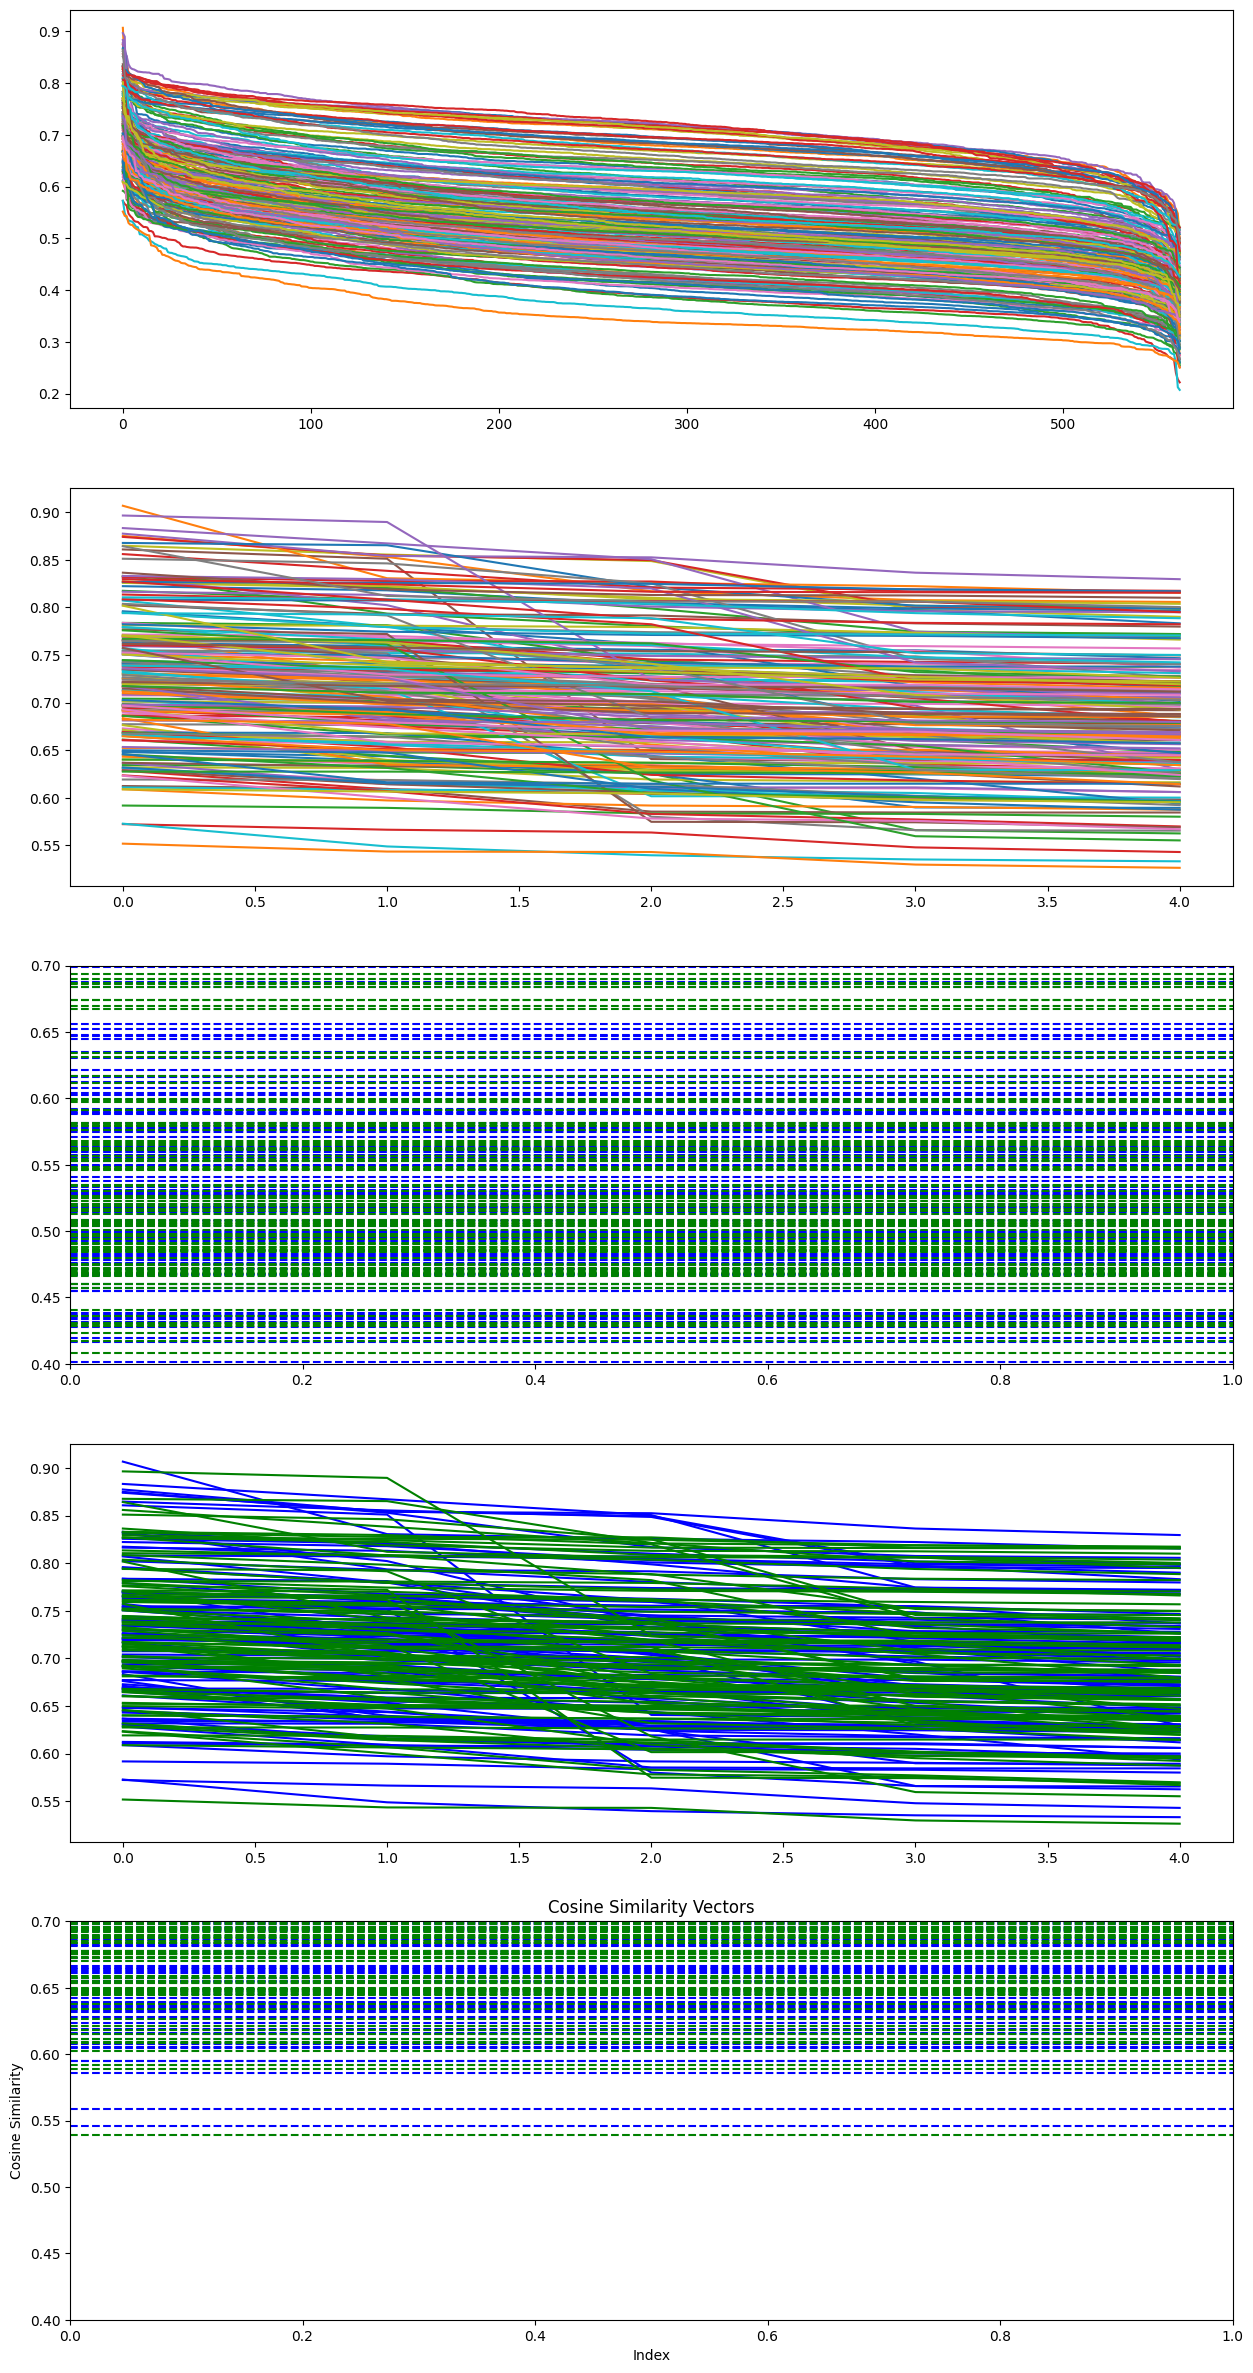

In [14]:
import matplotlib.pyplot as plt

class_stats = load_json("class_analysis/class_analysis_cub.json")
print(class_stats["American Crow"]["cosine_similarity_vector"])

class_list = compute_class_list(class_stats, True)
# class_list = exceptional_classes

# Create a new figure
plt.figure(figsize=(15, 30))

# Create a vector of 10 different flags for line colour in a matplotlib plot
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']

# Loop through each class_name in class_stats
i = 0
for class_name in class_list:
    # colour = colours[i]

    if i < len(class_list) / 2:
        colour = colours[0]
    else:
        colour = colours[1]

    class_stats[class_name]["cosine_similarity_vector"] = sorted(class_stats[class_name]["cosine_similarity_vector"], key=abs, reverse=True)
    cosine_similarity_vector = class_stats[class_name]['cosine_similarity_vector']
    similarity_average = sum(cosine_similarity_vector) / len(cosine_similarity_vector)
    cosine_similarity_vector_top5 = cosine_similarity_vector[:5]
    similarity_average_top5 = sum(cosine_similarity_vector_top5) / len(cosine_similarity_vector_top5)
    plt.subplot(5, 1, 1)
    plt.plot(cosine_similarity_vector, label=class_name)
    plt.subplot(5, 1, 2)
    plt.plot(cosine_similarity_vector_top5, label=class_name + " Top 5")
    plt.subplot(5, 1, 3)
    plt.ylim(0.4, 0.7)
    plt.axhline(y=similarity_average, color=colour, linestyle='--', label='Average: ' + class_name)
    plt.subplot(5, 1, 4)
    plt.plot(cosine_similarity_vector_top5, color=colour, label=class_name)
    plt.subplot(5, 1, 5)
    plt.axhline(y=similarity_average_top5, color=colour, linestyle='--', label='Average: ' + class_name)
    plt.ylim(0.4, 0.7)
    i += 1

# Add title and labels
plt.title('Cosine Similarity Vectors')
plt.ylabel('Cosine Similarity')
plt.xlabel('Index')

# Add a legend
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, -0.05))

# Show the plot
plt.show()

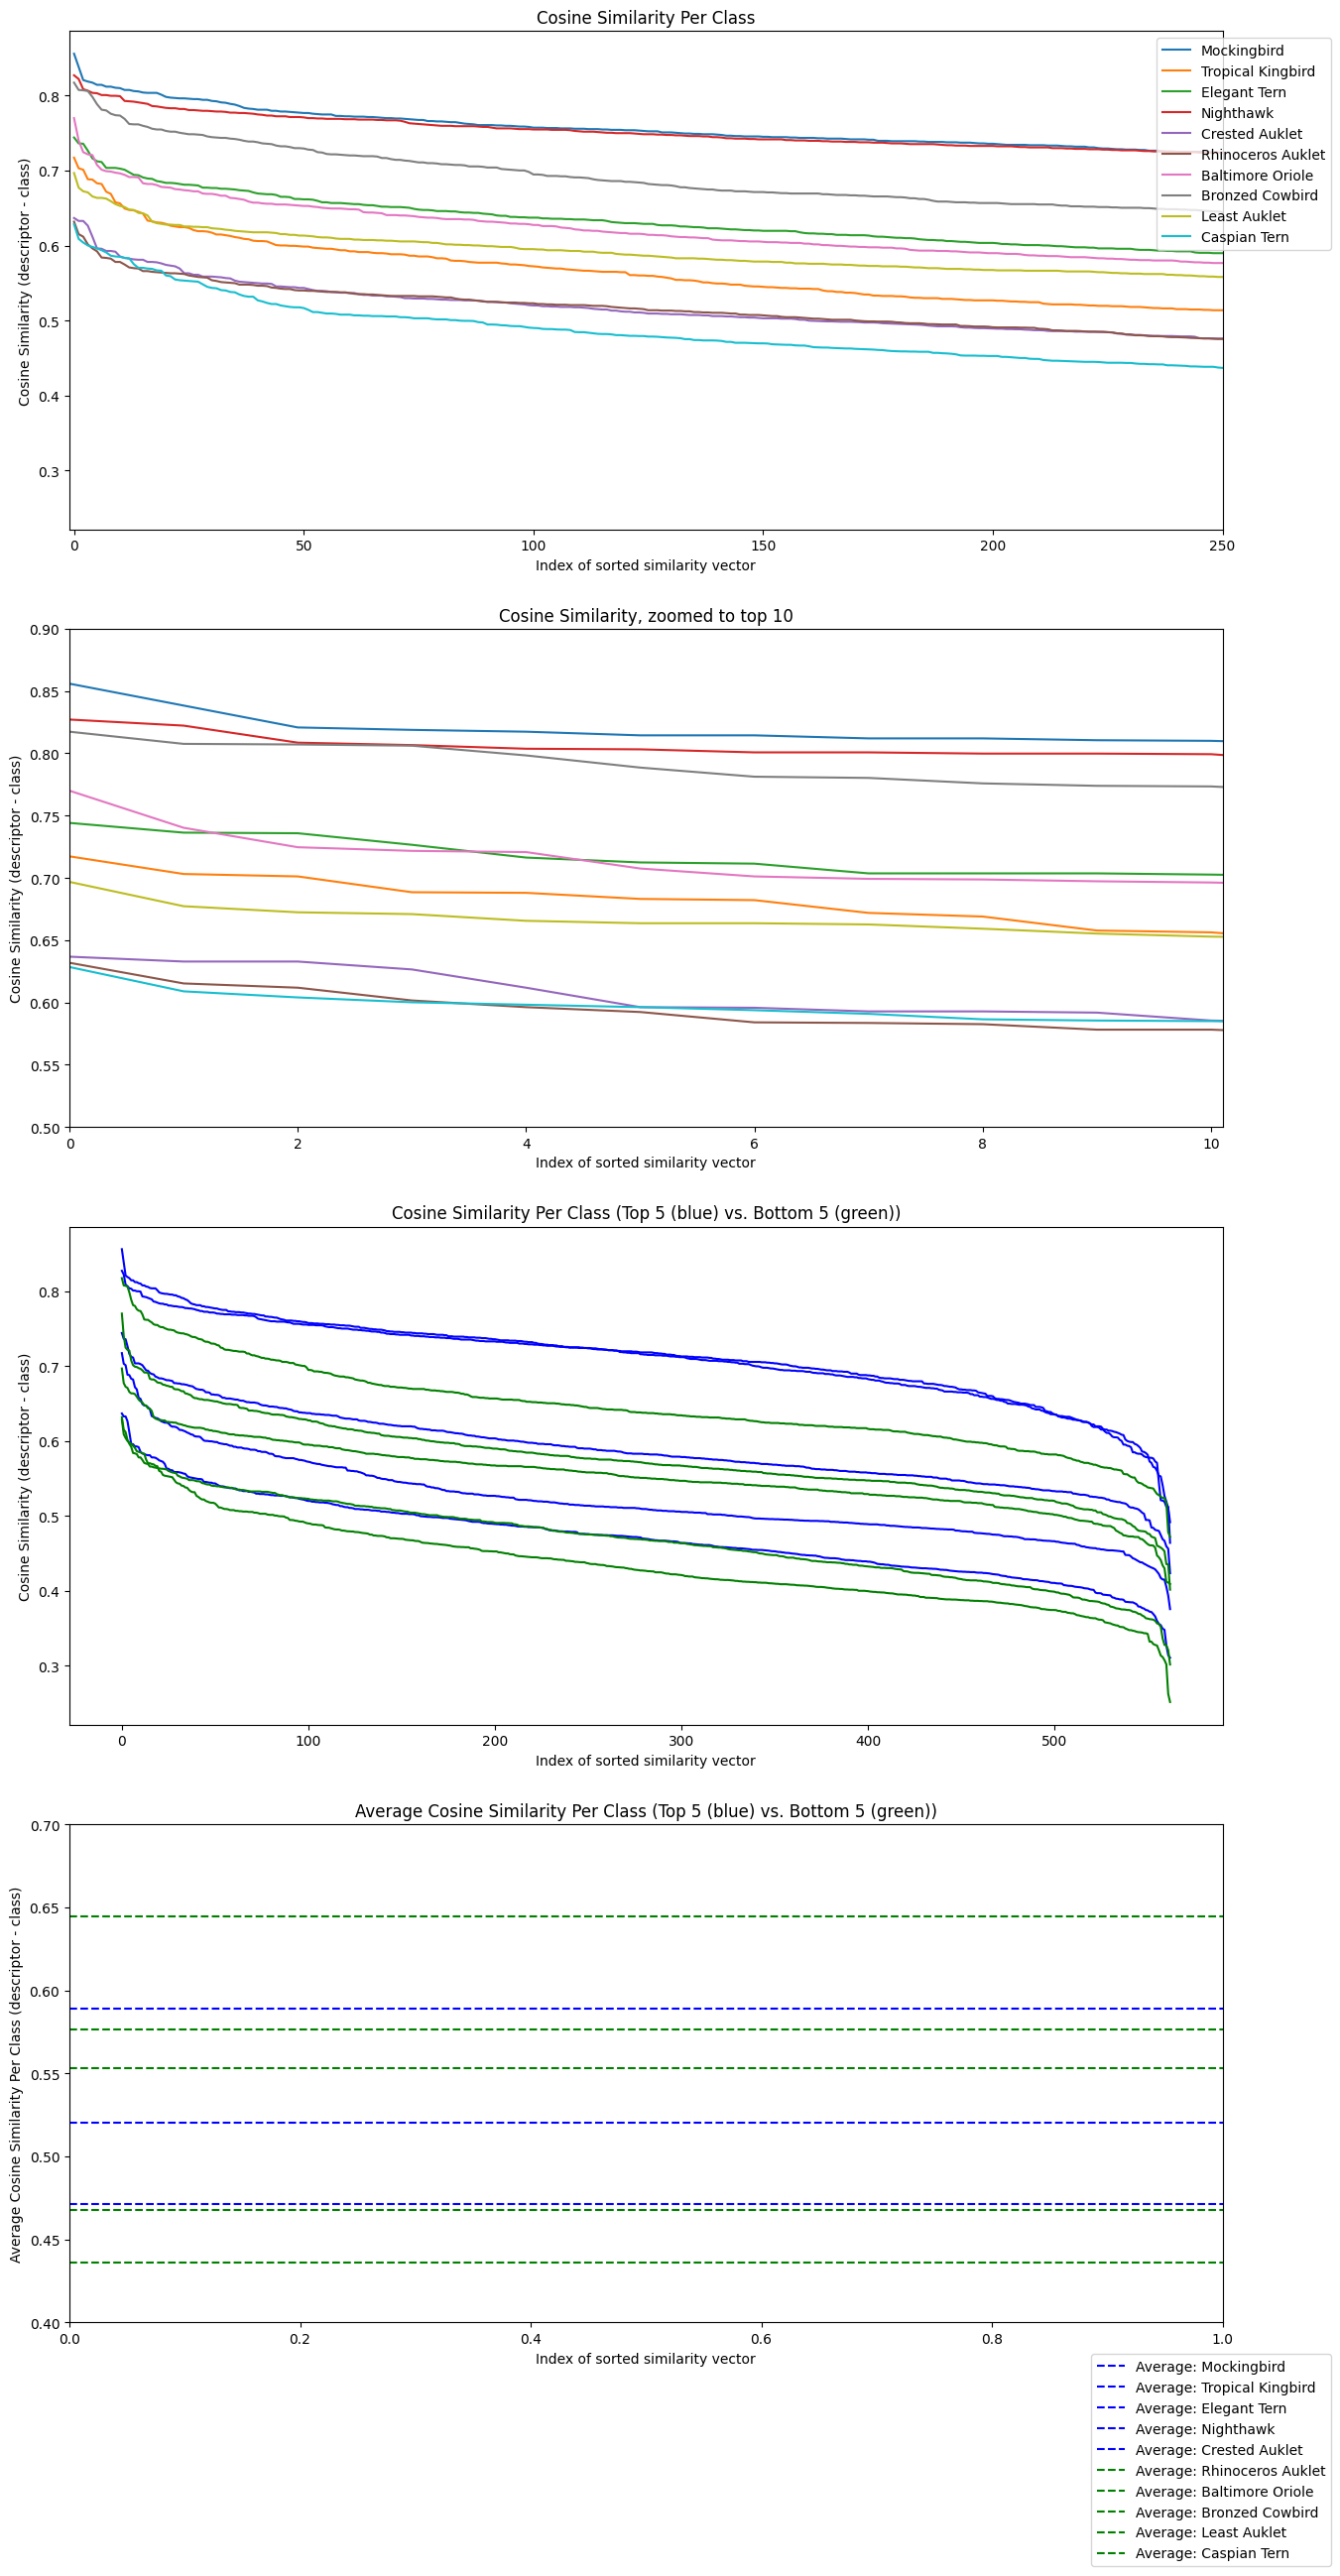

In [15]:
import matplotlib.pyplot as plt

class_stats = load_json("class_analysis/class_analysis_cub.json")
exp_results = load_json("results/experiment_results.json")

class_list = compute_class_list(class_stats, True)
class_list = exceptional_classes

# Create a new figure
plt.figure(figsize=(15, 30))

# Create a vector of 10 different flags for line colour in a matplotlib plot
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']

# Loop through each class_name in class_stats
i = 0
dataset_fraction = 0.025
colour = colours[0]
for class_name in class_list:


    if i < 20:
        if i < len(class_list) / 2:
            colour = colours[0]
        else:
            colour = colours[1]
    # else:
    #     if i < len(class_list) * dataset_fraction:
    #         colour = colours[0]
    #     elif i > len(class_list) * (1 - dataset_fraction):
    #         colour = colours[1]
    #     else:
    #         # Remove entry from similarity_average and cosine_similarity_vector
    #         class_stats.pop(class_name)
    #         i += 1
    #         continue

    class_stats[class_name]["cosine_similarity_vector"] = sorted(class_stats[class_name]["cosine_similarity_vector"], key=abs, reverse=True)
    cosine_similarity_vector = class_stats[class_name]['cosine_similarity_vector']
    similarity_average = sum(cosine_similarity_vector) / len(cosine_similarity_vector)

    plt.subplot(4, 1, 1)
    plt.plot(cosine_similarity_vector, label=class_name)
    plt.title('Cosine Similarity Per Class')
    plt.ylabel('Cosine Similarity (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')
    plt.xlim(-1, 250)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.subplot(4, 1, 2)
    plt.plot(cosine_similarity_vector, label=class_name)
    plt.xlim(0,10.1)
    plt.ylim(0.5, 0.9)
    plt.title('Cosine Similarity, zoomed to top 10')
    plt.ylabel('Cosine Similarity (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')

    plt.subplot(4, 1, 3)
    plt.plot(cosine_similarity_vector, color=colour, label=class_name)
    plt.title('Cosine Similarity Per Class (Top 5 (blue) vs. Bottom 5 (green))')
    plt.ylabel('Cosine Similarity (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')

    plt.subplot(4, 1, 4)
    plt.ylim(0.4, 0.7)
    plt.axhline(y=similarity_average, linestyle='--', color=colour, label='Average: ' + class_name)
    plt.title('Average Cosine Similarity Per Class (Top 5 (blue) vs. Bottom 5 (green))')
    plt.ylabel('Average Cosine Similarity Per Class (descriptor - class)')
    plt.xlabel('Index of sorted similarity vector')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, -0.05))

    i += 1

# Add a legend


# Show the plot
plt.show()

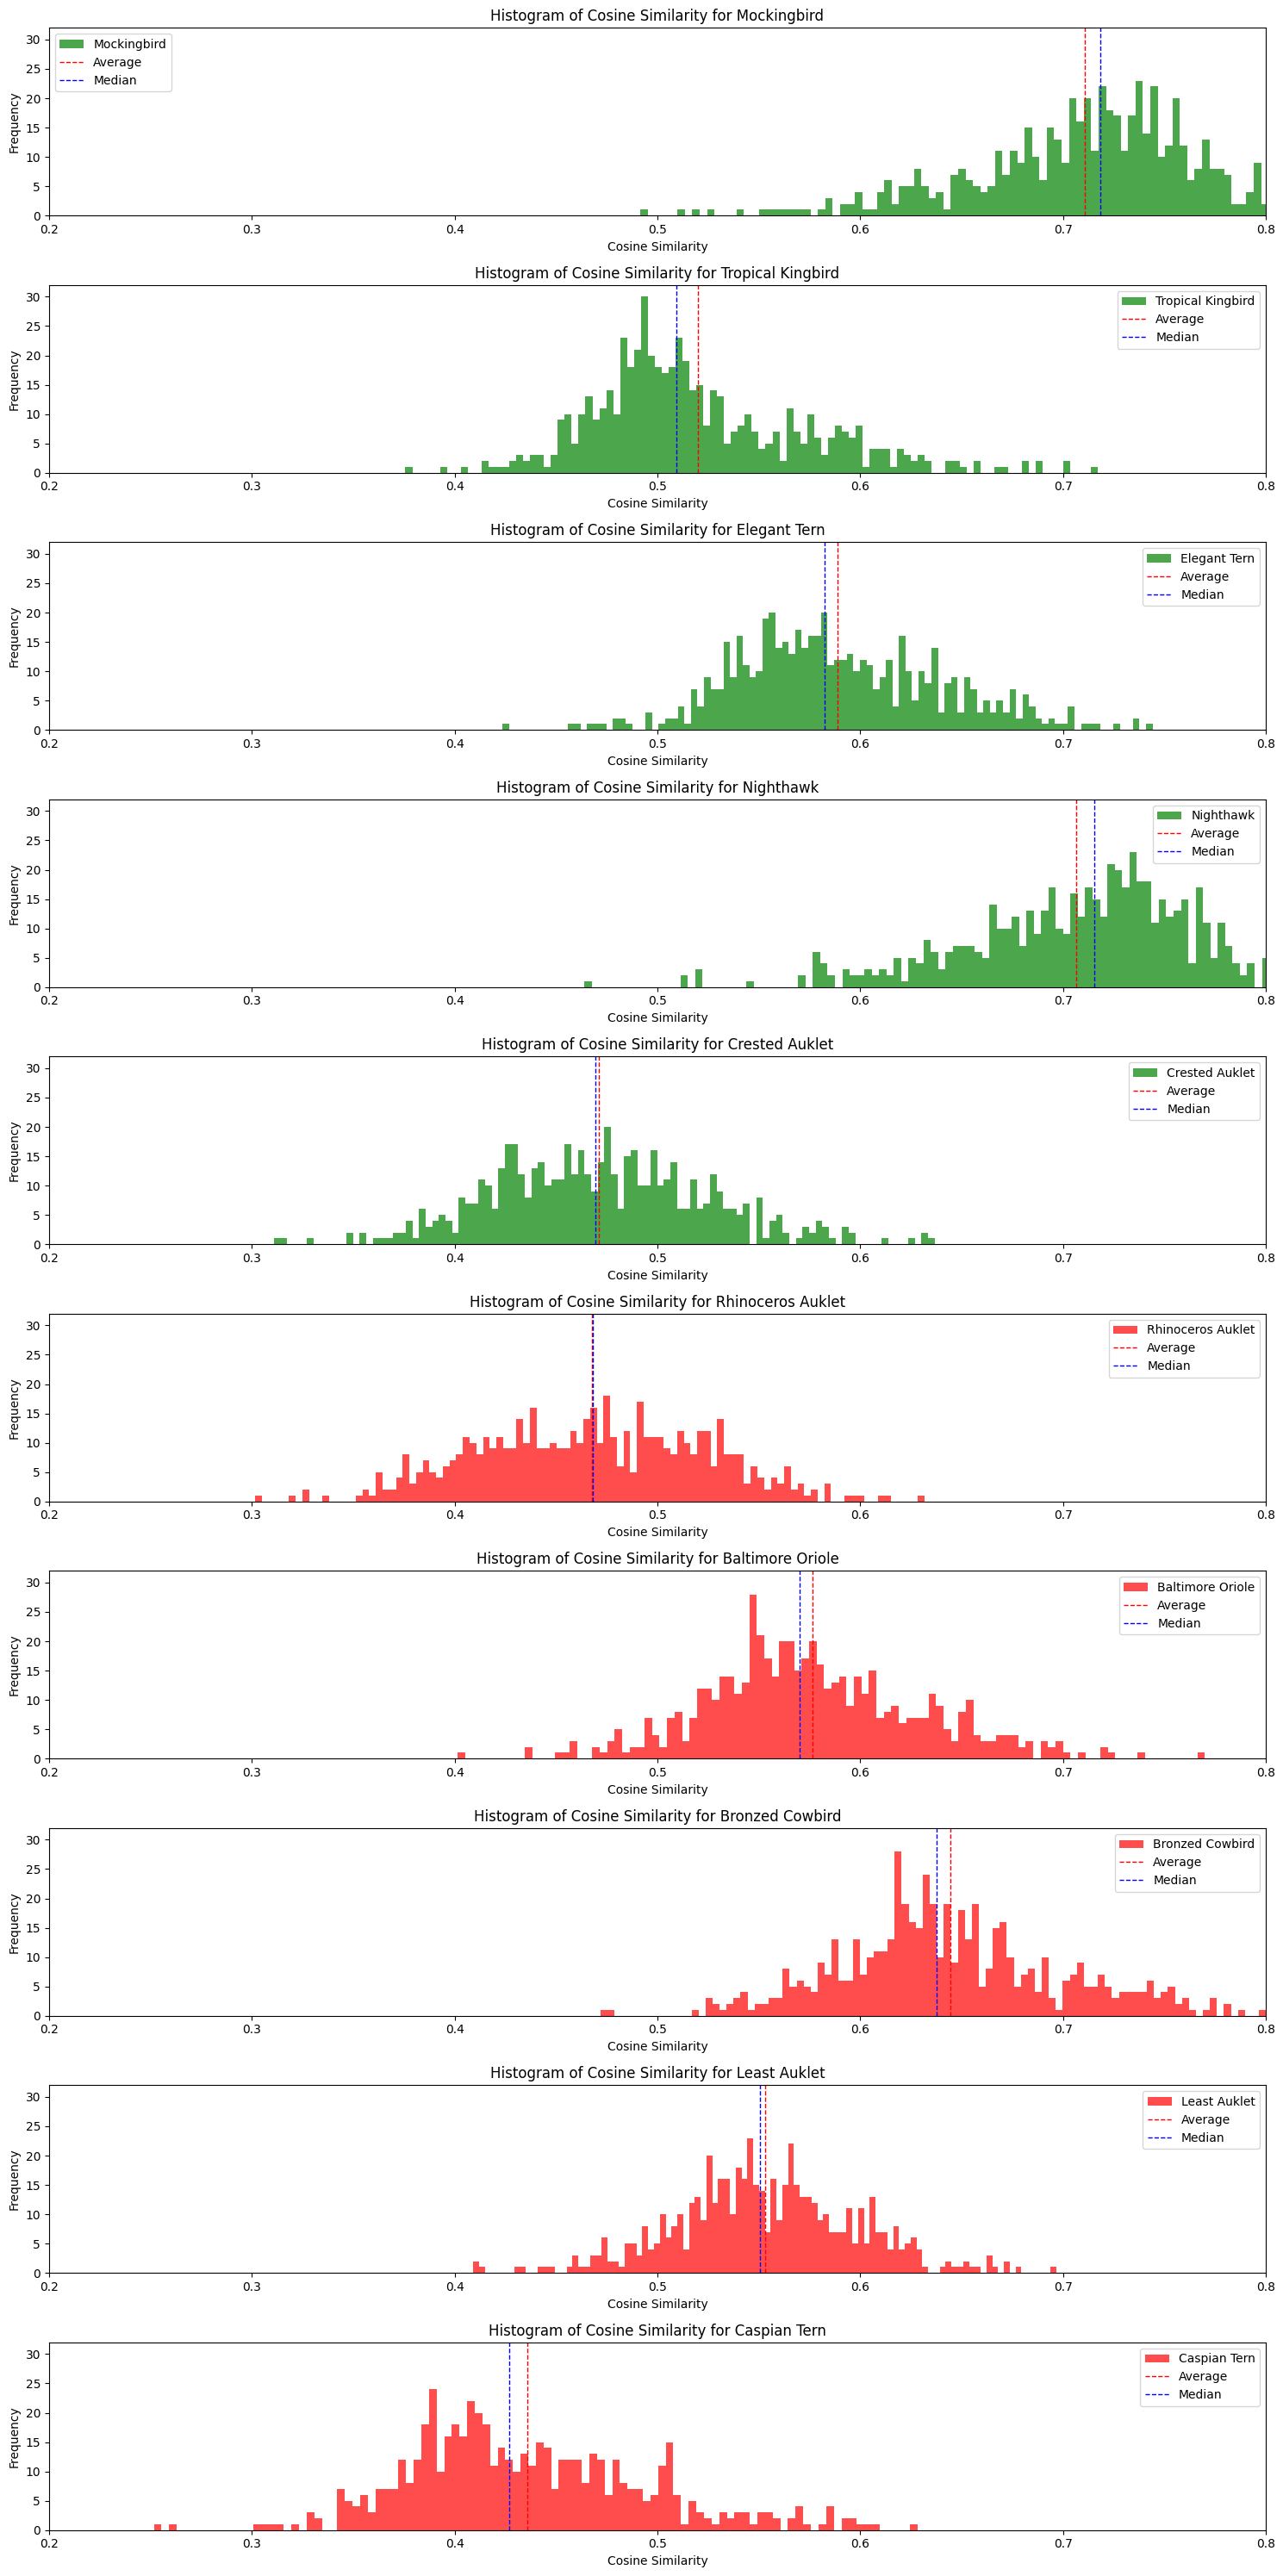

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming load_json and compute_class_list functions are defined elsewhere
class_stats = load_json("class_analysis/class_analysis_cub.json")
exp_results = load_json("results/experiment_results.json")

class_list = compute_class_list(class_stats, True)
class_list = exceptional_classes

# Create a new figure for histograms
plt.figure(figsize=(15, 30))

# Loop through each class_name in class_list and plot histogram
i = 0
for class_name in class_list:
    if i < len(class_list) / 2:
        color = 'g'
    else:
        color = 'r'
    cosine_similarity_vector = class_stats[class_name]["cosine_similarity_vector"]
    similarity_average = np.mean(cosine_similarity_vector)
    similarity_median = np.median(cosine_similarity_vector)
    
    plt.subplot(len(class_list), 1, i+1)
    plt.hist(cosine_similarity_vector, bins=100, alpha=0.7, color=color, label=class_name)
    plt.axvline(similarity_average, color='r', linestyle='--', linewidth=1, label='Average')
    plt.axvline(similarity_median, color='b', linestyle='--', linewidth=1, label='Median')
    
    plt.title(f'Histogram of Cosine Similarity for {class_name}')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.xlim(0.2, 0.8)
    plt.ylim(0, 32)
    plt.legend()

    i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the histogram plot
plt.show()


In [1]:
from class_analysis import *

similarity, class_list, descriptor_list = compute_class_description_cosine_similarity("class_analysis/class_analysis_cub.json")

Creating descriptors...

Example description for class Black-footed Albatross: "Black-footed Albatross, which is a seabird"

Creating descriptor frequencies...


AttributeError: 'dict' object has no attribute 'endswith'